1. Gather the data and determine the problem to be solved.

In [2]:
import pandas as pd

blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
target_name = "Class"
data = blood_transfusion.drop(columns=target_name)
target = blood_transfusion[target_name]

blood_transfusion[target_name].value_counts()

Class
not donated    570
donated        178
Name: count, dtype: int64

### Overview of the dataset
- The problem to be solved is to predict whether a person has donated or not based on various features.
- There're 2 possible values for the target variable: 0 (not donated) and 1 (donated). => This is a binary classification problem.
- But the dataset is imbalanced: ~76% is not donated, ~24% is donated. => We need to handle the imbalance in the dataset.

2. Use a Dummy Classifier to establish a baseline performance.

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

dummy = DummyClassifier(strategy='most_frequent')
dummy_cv_results = cross_validate(
    dummy,
    data,
    target,
    cv=10,
    n_jobs=2
)

print(f'The baseline performance is : {dummy_cv_results['test_score'].mean():.3f}')

The baseline performance is : 0.762


- As we expected, the Dummy Classifier has a accuracy of 76%, which is the same as the proportion of the not donated class.
- This is our baseline performance. Which means any model we build should perform better than this.

3. Let's try again with scoring='balanced_accuracy' to account for the class imbalance.

In [14]:
dummy_cv_results = cross_validate(
    dummy,
    data,
    target,
    cv=10,
    n_jobs=2,
    scoring='balanced_accuracy'
)

print(f'The baseline performance is : {dummy_cv_results['test_score'].mean():.3f}')

The baseline performance is : 0.500


As expected, we get a balanced accuracy of 50%, which is the same as random guessing.

4. Let's preprocess the data and try a KNeighborsClassifier model.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

transformer = make_pipeline(
    StandardScaler()
)

preprocessor = make_column_transformer(
    (transformer, data.columns)
)

model = make_pipeline(
    preprocessor,
    KNeighborsClassifier()
)

print(f' The default value for n_neighbors is: {model.get_params()['kneighborsclassifier__n_neighbors']}')

# Let's update it to 1
model.set_params(kneighborsclassifier__n_neighbors = 1)

 The default value for n_neighbors is: 5


,steps,"[('columntransformer', ...), ('kneighborsclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


5. Then evaluate the model using cross-validation.

In [30]:
k_neighbors_cv = cross_validate(
    model,
    data,
    target,
    cv=10,
    scoring='balanced_accuracy',
    error_score='raise',
    return_train_score=True
)

print(f'Accuracy on train data of KNeighborsClassifier: {k_neighbors_cv['train_score'].mean():.3f} +- {k_neighbors_cv['train_score'].std():.3f}')
print(f'Accuracy on test data of KNeighborsClassifier: {k_neighbors_cv['test_score'].mean():.3f} +- {k_neighbors_cv['test_score'].std():.3f}')

Accuracy on train data of KNeighborsClassifier: 0.883 +- 0.008
Accuracy on test data of KNeighborsClassifier: 0.484 +- 0.105


=> This clearly indicates that the model is currently overfitting, since the training score is significantly higher than the test score. Also, the test score (48%) is even lower than our baseline performance of 76% accuracy.

6. Let's use Validation Curve to tune the hyperparameter 'n_neighbors'. Also, we gonna use 5-fold cross-validation instead of 10-fold.

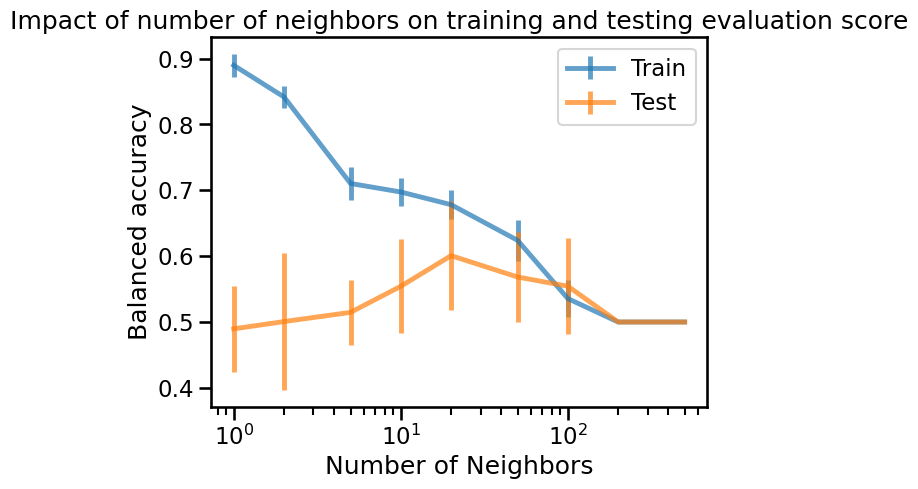

In [32]:
from sklearn.model_selection import ValidationCurveDisplay
import numpy as np

param_range = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500])

validation_curve_display = ValidationCurveDisplay.from_estimator(
    estimator= model,
    X= data,
    y= target,
    param_range= param_range,
    param_name='kneighborsclassifier__n_neighbors',
    cv= 5,
    scoring='balanced_accuracy',
    n_jobs=2,
    errorbar_kw={'alpha': 0.7},
    error_score='raise',
    std_display_style='errorbar'
)

_ = validation_curve_display.ax_.set(
    xlabel = "Number of Neighbors",
    title = "Impact of number of neighbors on training and testing evaluation score"
)